In [1]:
# Data related libraries
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
from IPython.display import display, HTML

# Convenient helpers
from copy import copy
from time import time
from collections import defaultdict, Counter
from sklearn.preprocessing import minmax_scale

# Printing libraries and settings
# import warnings; warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format','{0:.2f}'.format)

try:
    # nicer error output
    import stackprinter
    stackprinter.set_excepthook(style='color')
except:
    pass

%matplotlib inline

# Loss-function

In [2]:
def rastrigin3(X):
    return 3. + np.sum((X**2 - 3. * np.cos(2 * np.pi * X)), -1)

## Plot Loss-function in 3D

In [3]:
low, high, size = -5, 5, 100
spacing = np.linspace(low, high, size)  
xx, yy = np.meshgrid(spacing, spacing)
grid = np.stack((xx, yy), -1)

Z = rastrigin3(grid).T

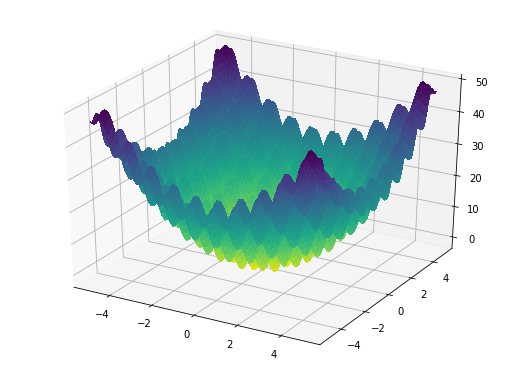

In [4]:
from mpl_toolkits.mplot3d import axes3d, Axes3D

fig = plt.figure(figsize=(7,5))
ax = Axes3D(fig)

ax.plot_surface(xx, yy, Z, rstride=1, cstride=1, cmap=plt.cm.viridis_r, linewidth=0, antialiased=False)
plt.show()

## Plot Loss-function in 2d

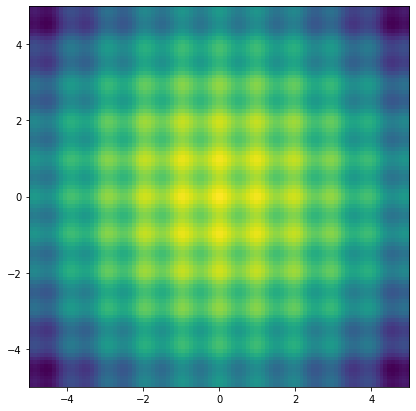

In [5]:
extent = np.min(xx), np.max(xx), np.min(yy), np.max(yy)

fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(Z, cmap=plt.cm.viridis_r, extent=extent, origin='lowerleft')
plt.show()

## find pixel-area in image with lowest function value

In [6]:
def minimum_in_image(function):
    low, high, size = -10, 10, 1000
    spacing = np.linspace(low, high, size)  
    xx, yy = np.meshgrid(spacing, spacing)
    grid = np.stack((xx, yy), -1)
    Z = function(grid).T

    return grid[np.unravel_index(np.argmin(Z), Z.shape)]

print(minimum_in_image(rastrigin3))

[-0.01001001 -0.01001001]


# CMA-ES step-by-step

## Define Loss-function

In [7]:
function = rastrigin3

## Initial values

In [8]:
n = 50 # num samples
k = 10 # top-k asmples

mean = [1.9, -2.7] # initial mean of sample
cov = 0.5*np.eye(2)    # initial sampling covariance matrix

## Draw n samples

In [9]:
X = np.random.multivariate_normal(mean=mean, cov=cov, size=n)

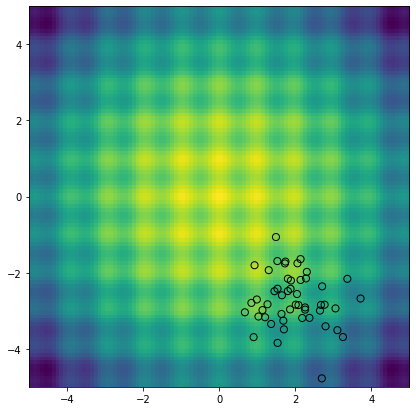

In [10]:
extent = np.min(xx), np.max(xx), np.min(yy), np.max(yy)

fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(Z, cmap=plt.cm.viridis_r, extent=extent, origin='lowerleft')
ax.scatter(X.T[0], X.T[1], facecolor='none', color='k', s=50)
plt.show()

## Calculate their loss

In [11]:
losses = function(X)

## Keep top-k samples with lowest loss

In [12]:
arg_topk = np.argsort(losses)[:k]
topk = X[arg_topk]
topk

array([[ 0.92870593, -1.80533605],
       [ 1.49102518, -1.06475618],
       [ 1.30138455, -1.93427297],
       [ 2.05630755, -1.75453528],
       [ 1.1379425 , -2.98414094],
       [ 1.80419379, -2.16016663],
       [ 1.88438331, -2.20661628],
       [ 0.84573984, -2.7949612 ],
       [ 0.98864791, -2.70546983],
       [ 1.03123304, -3.15312336]])

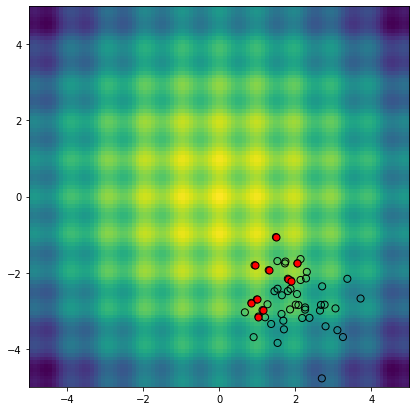

In [13]:
extent = np.min(xx), np.max(xx), np.min(yy), np.max(yy)

fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(Z, cmap=plt.cm.viridis_r, extent=extent, origin='lowerleft')
ax.scatter(X.T[0], X.T[1], facecolor='none', color='k', s=50)
ax.scatter(topk.T[0], topk.T[1], facecolor='r', color='k', s=50)
plt.show()

## Calculate adapted (2d) Covariance-matrix

Calculate all entries of the adapted covariance matrix $\mathcal{C}$ over all $k$ data records $x \in \mathbb{R}^n$ with
$$c_{ij} = \frac{1}{(k-1)}\sum_{l=0}^k(x_{i,l} - \mu_i)(x_{j,l} - \mu_j)$$

In [14]:
mean_all = X.T.mean(axis=1)

dim = topk.shape[1]
C = np.zeros((dim,dim))

for i in range(dim):
    for j in range(dim):
        Cij = 0
        for t in topk:
            Cij += (t[i] - mean_all[i])*(t[j] - mean_all[j])
        C[i,j] = Cij/(k-1)
C

array([[ 0.59440653, -0.16480359],
       [-0.16480359,  0.65470633]])

**Note:** A tighter way for the same calculation

In [15]:
(topk - mean_all).T.dot(topk - mean_all)/(k-1)

array([[ 0.59440653, -0.16480359],
       [-0.16480359,  0.65470633]])

## Take new samples around $\varnothing(top-k)$ samples with a Covariance-matrix $\mathcal{C}$

In [16]:
mean_topk = topk.T.mean(axis=1)
X = np.random.multivariate_normal(mean=mean_topk, cov=C, size=n)

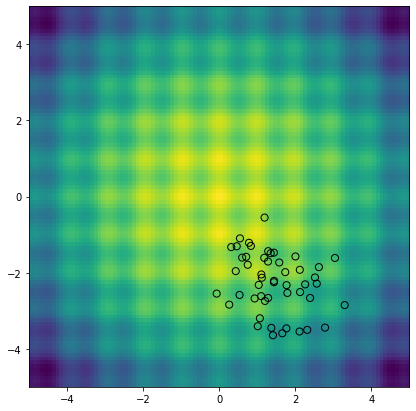

In [17]:
extent = np.min(xx), np.max(xx), np.min(yy), np.max(yy)

fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(Z, cmap=plt.cm.viridis_r, extent=extent, origin='lowerleft')
ax.scatter(X.T[0], X.T[1], facecolor='none', color='k', s=50)
plt.show()

## Rinse and repeat... until convergence

# CMA-ES as Algorithm

In [18]:
class CMAES():
    def __init__(self, function, n=50, k=10, mean=np.zeros(2), cov = np.eye(2), alpha=0.5, max_iter=10):
        self.function = function
        self.n = n
        self.k = k
        self.mean_all = mean
        self.mean_topk = mean
        self.C = cov
        self.alpha=alpha
        self.max_iter = max_iter
        self.old_optimum = mean
        
        # Draw n samples
        self.X = np.random.multivariate_normal(mean=self.mean_all, cov=self.C, size=self.n)
        self.topk = mean

        
    def update(self, show=True):
        # Calculate the loss of the samples
        losses = self.function(self.X)
        
        # Keep top-k samples with lowest loss
        arg_topk = list(np.argsort(losses)[:self.k])
        self.topk = self.X[arg_topk]
        
        if show:
            self.show()
        
        # Calculate adapted Covariance-matrix
        mean_all = self.X.T.mean(axis=1)
        centered = self.topk - mean_all
        self.C = centered.T.dot(centered)/(self.k-1)

        # Take new samples around mean(top−k) samples with a Covariance-matrix C
        self.mean_topk = self.topk.T.mean(axis=1)
        self.X = np.random.multivariate_normal(mean=self.mean_topk, cov=self.C, size=self.n)
    
    
    def show(self):
        low, high, size = -10, 10, 100
        spacing = np.linspace(low, high, size)  
        xx, yy = np.meshgrid(spacing, spacing)
        grid = np.stack((xx, yy), -1)
        Z = self.function(grid).T
        
        extent = np.min(xx), np.max(xx), np.min(yy), np.max(yy)
        fig, ax = plt.subplots(figsize=(5,5))
        ax.imshow(Z, cmap=plt.cm.viridis_r, extent=extent, origin='lowerleft')
        losses = self.function(self.X)
        colors = plt.cm.Blues(minmax_scale(losses))
        ax.scatter(self.X.T[0], self.X.T[1], color=colors, s=50)
        ax.scatter(self.topk.T[0], self.topk.T[1], facecolor='none', color='k', s=50)
        plt.show()

    
    def optimize(self):
        for step in range(self.max_iter):
            self.old_optimum = self.topk[0]
            self.update()
            if np.linalg.norm(self.old_optimum - self.topk[0]) < 0.005:
                break
        return self.topk[0]       

## Examples

## Rastrigri Function

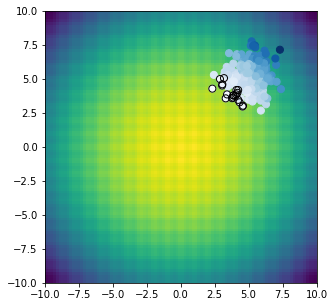

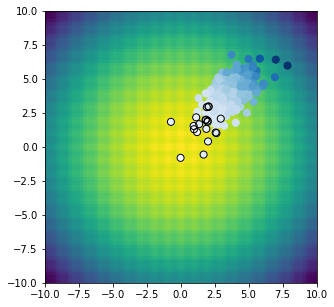

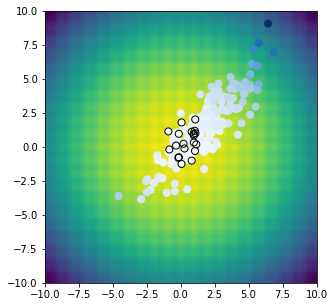

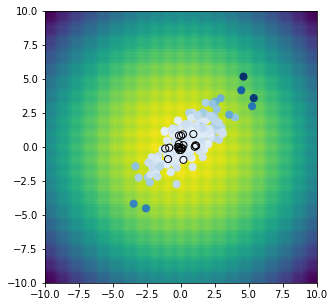

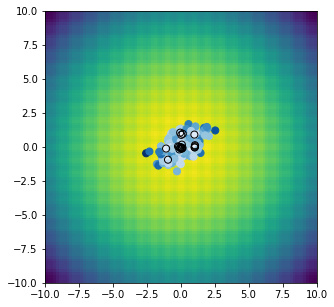

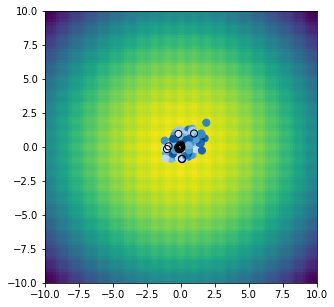

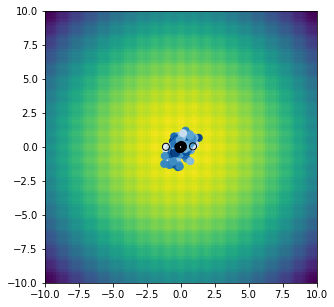

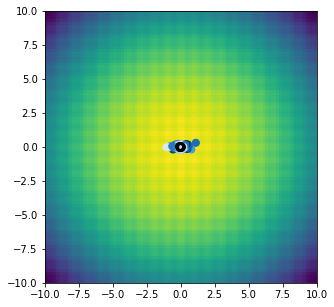

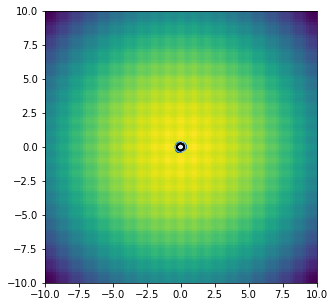

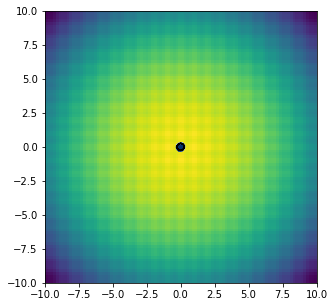

array([ 0.00074973, -0.00126961])

In [19]:
myCMAES = CMAES(rastrigin3, n=200, k=20, mean=[5,5], max_iter=20)
myCMAES.optimize()

In [20]:
print(minimum_in_image(rastrigin3))

[-0.01001001 -0.01001001]


## Log(Rosenbrock+1)

In [21]:
def log_rosenbrock(X, a=1, b=100):
    x,y = X.T
    return np.log((a-x)**2 + b*(y-x**2)**2 + 1.)

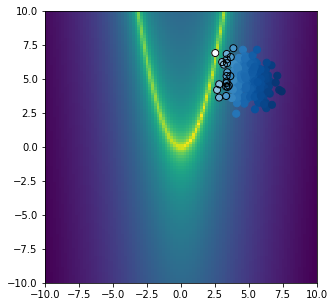

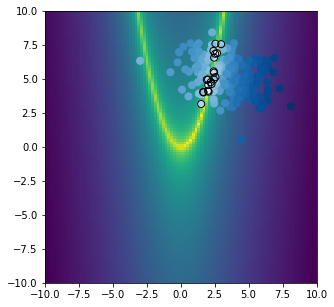

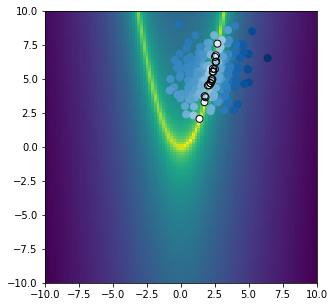

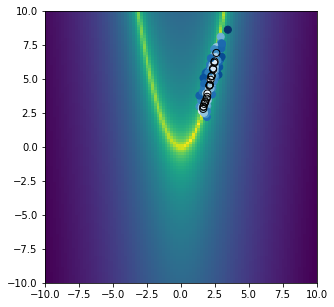

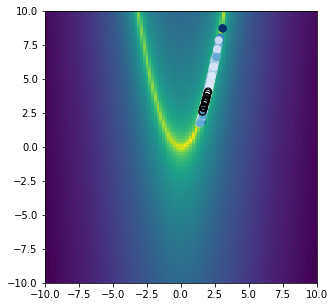

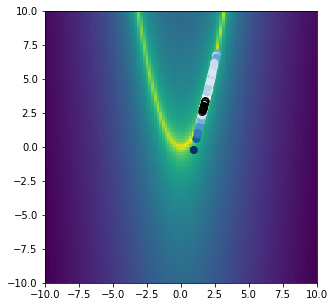

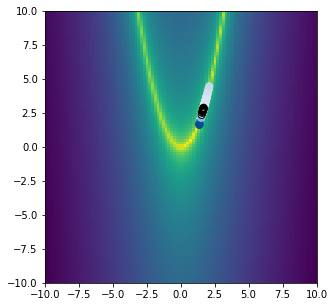

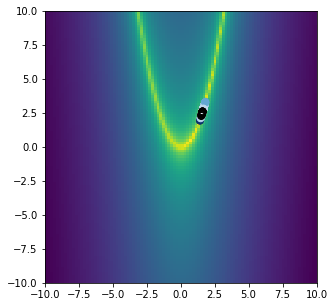

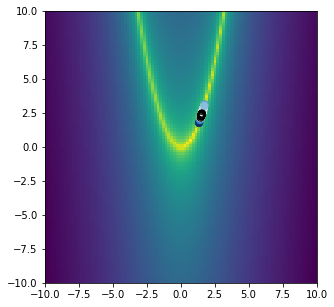

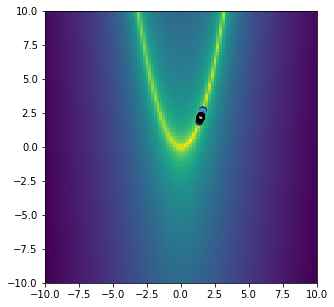

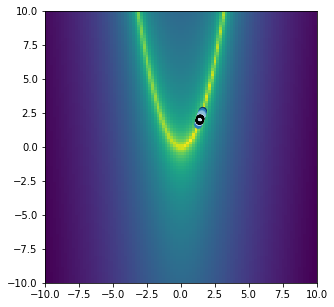

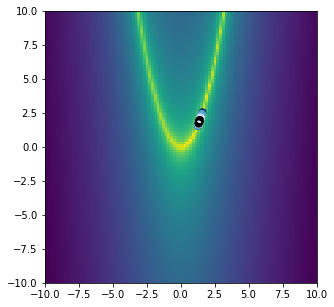

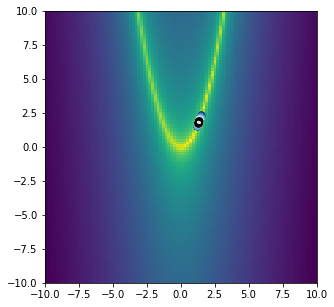

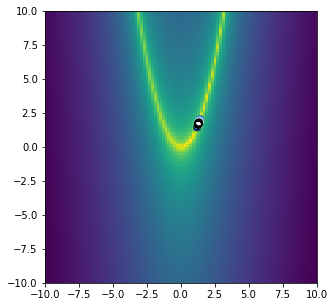

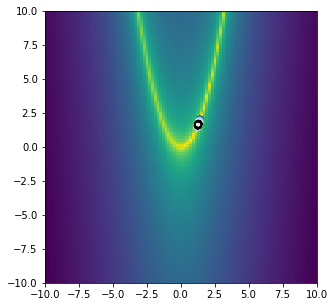

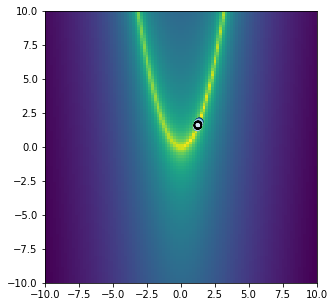

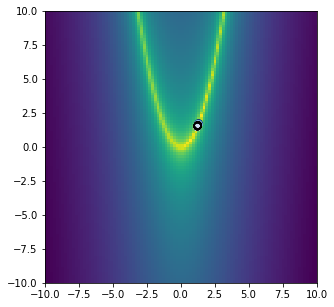

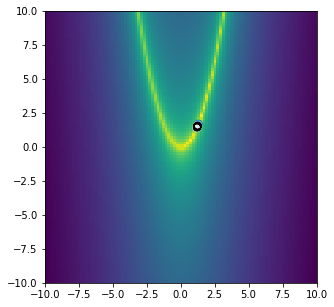

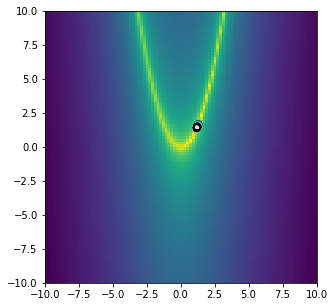

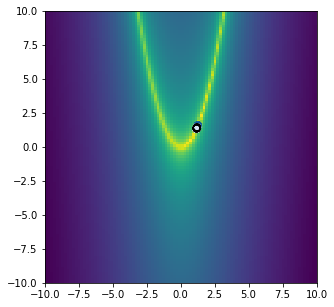

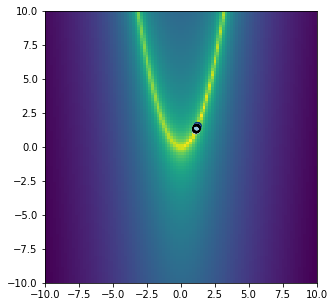

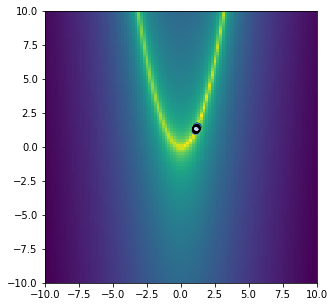

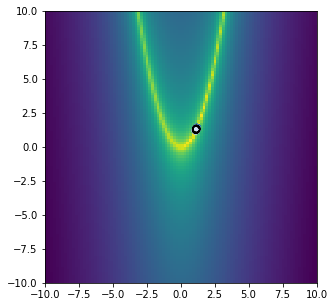

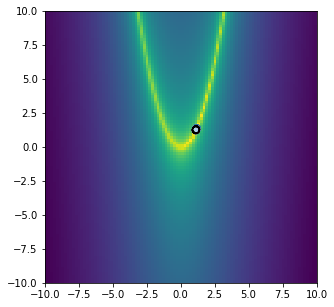

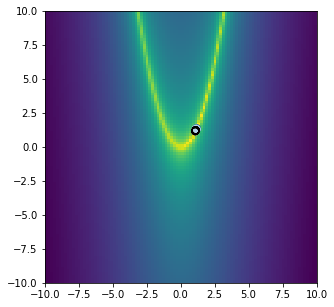

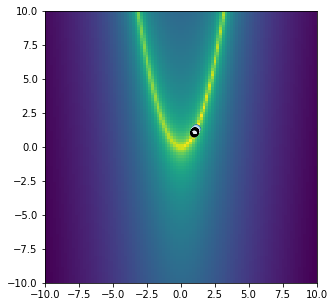

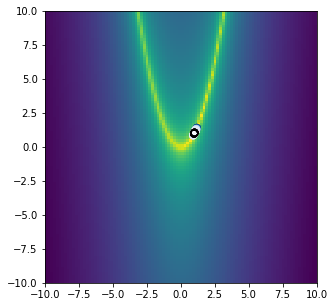

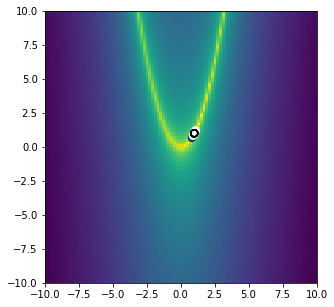

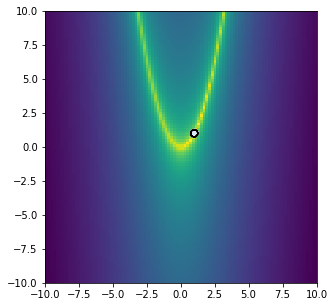

array([1.00037071, 1.00068593])

In [22]:
myCMAES = CMAES(log_rosenbrock, n=200, k=20, mean=[5,5], max_iter=30)
myCMAES.optimize()

In [23]:
print(minimum_in_image(log_rosenbrock))

[0.93093093 0.87087087]


## Diamond

In [24]:
def diamond(X):
    x,y = X.T
    return np.sqrt((x+3)**2) + np.sqrt((y-2)**2)

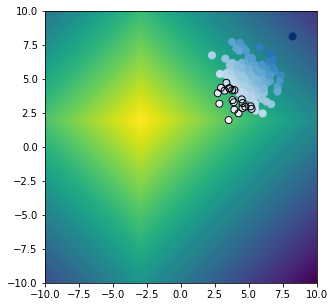

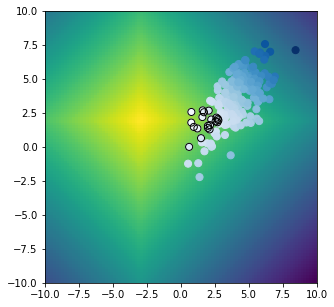

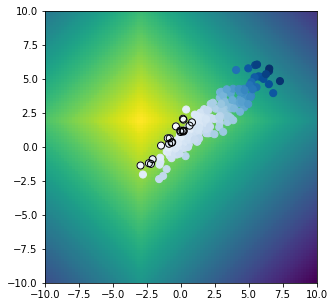

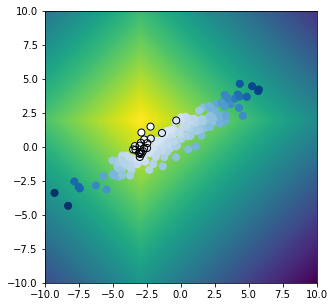

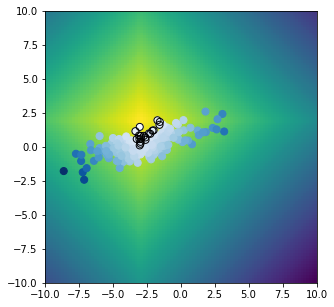

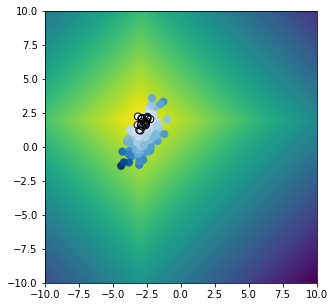

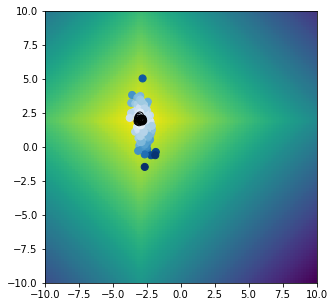

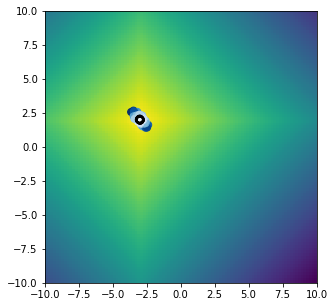

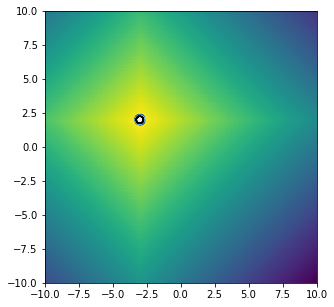

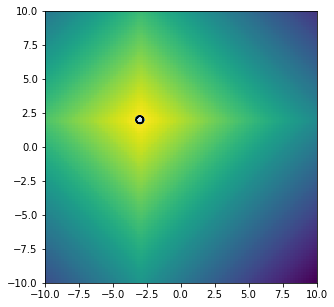

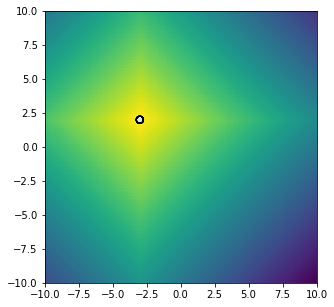

array([-2.99987653,  2.00048813])

In [25]:
myCMAES = CMAES(diamond, n=200, k=20, mean=[5,5], max_iter=20)
myCMAES.optimize()

In [26]:
print(minimum_in_image(diamond))

[-2.99299299  1.99199199]
